In [1]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
from pathlib import Path
from pthflops import count_ops
from tqdm import tqdm

print(torch.__version__)
torch.manual_seed(42)
np.random.seed(seed=42)
random.seed(42)


2.0.1+cu118


tensor([[[[0.0235, 0.0235, 0.0235],
          [0.0392, 0.0392, 0.0392],
          [0.0471, 0.0471, 0.0471],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          [0.0157, 0.0157, 0.0157],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0039, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000

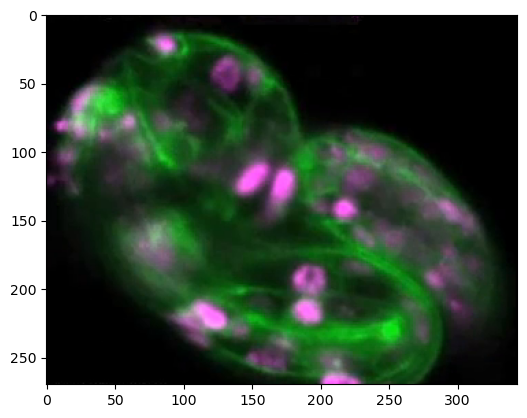

In [2]:
#Load video file - RUN ONCE
vRead = iio.imread('data/c_elegans.mp4')
video = np.array(vRead)
video = torch.as_tensor(video)
testFrame = video[0]
### Crop letters from video
def writeVideoMOV(videoTensor, filename='decoded'):

    w = iio.get_writer(filename + '.mov', format='FFMPEG', mode='I', fps=20,
                        codec='h264_vaapi',
                        output_params=['-vaapi_device',
                                        '/dev/dri/renderD128',
                                        '-vf',
                                        'format=gray|nv12,hwupload'],
                        pixelformat='vaapi_vld')
    for frame in videoTensor:
        w.append_data(frame.numpy())
    w.close()
    print('video saved in local directory as: ' + filename + '.mov')
    return None

croppedVideo = torch.zeros((2484, 270, 344,3)).type(torch.float32)
for i in range(len(video)):
    croppedVideo[i] = video[i][18:288]
#Normalize range of RGBs
croppedVideo = torch.mul(croppedVideo, 1/255.0).type(torch.float32)
plt.imshow(croppedVideo[100])
#writeVideoMOV(croppedVideo, filename="cropped_C_Elegans")
#Set Video to cropped version
video = croppedVideo
print(video)

In [3]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:1")

    print("Is cuDNN version:", torch.backends.cudnn.version())

    print("cuDNN enabled:a", torch.backends.cudnn.enabled)

    print("Device count: ", torch.cuda.device_count())

    print("Current device: ", torch.cuda.current_device())

    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1
print(device)
video = video.to(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  3
Current device:  1
Device name:  NVIDIA TITAN Xp
cuda


In [54]:
#Encoding
#INPUT  = L * F
#Output = 3
class hashNerf(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int,
                L=16, T=2**18, F=2, N_min=16, N_max=512, num_output=3):
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.num_output = num_output
        super().__init__()

        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1)) # scalar : dim 1
        self.N_values = torch.floor(torch.tensor(np.float32(self.N_min * b ** np.arange(self.L)))).type(torch.int32).to(device) # dim : 16,1
        self.hash_table = nn.Parameter(torch.FloatTensor(16,2**18,2).uniform_(-1e-4, 1e-4)).to(device) # dim : L, T, F
        self.vertices = torch.transpose(torch.tensor([
                        [0,0],
                        [1,0],
                        [0,1],
                        [1,1]]), 0,1).type(torch.float32) # dim : (2,4)
        self.prime_numbers = torch.tensor([1, 2654435761]).type(torch.int64)

        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units), 
            nn.LeakyReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.Sigmoid()
        ).to(device)
    
    def forward(self, X):
        # X : 2D coordinates -> (num_points, 2)
        x_shape = X.shape
        """
        x_col = X[:,[0]] * self.N_values
        y_col = X[:, [1]] * self.N_values
        outputT = torch.zeros((len(x_col), L, 2)).type(torch.float32) # sca
        for i in range(len(x_col)):
            tempT = torch.zeros((L, 2))
            for j in range(L):
                tempT[j][0] = x_col[i][j]
                tempT[j][1] = y_col[i][j]
            outputT[i] = tempT
        """
        outputT = torch.zeros((len(X), 2, self.L)).type(torch.float32)
        for i in range(len(X)):
            outputT[i][0] = X[i][0] * self.N_values
            outputT[i][1] = X[i][1] * self.N_values
        x_scaled = outputT # dim : (batch_size, 2, L)
        x_floor = torch.floor(x_scaled) # dim : (batch_size, 2, L)
        x_ceil = torch.ceil(x_scaled) # dim : (batch_size, 2, L)

        x_vertices = torch.zeros((len(x_floor), 2, self.L, 4)) # dim : (batch_size, 2, L, 4)
        for i in range(len(x_floor)):
            # make sure to do x and y !
            for j in range(0,self.L):
                x_vertices[i][0][j] = outputT[i][0][j] * self.vertices[0]
                x_vertices[i][1][j] = outputT[i][1][j] * self.vertices[1]
        x_vertices = x_vertices.type(torch.int64)
        
        primesTemp = torch.tensor([1, 2654435761]).type(torch.int64)
        x_to_hash_temp = x_vertices * primesTemp[None, :, None, None]
        #print(x_to_hash_temp)
        #print(x_to_hash_temp.shape)

        x_hash_temp = torch.bitwise_xor(x_to_hash_temp[:, 0],
                                        x_to_hash_temp[:, 1]) # shape: num_points, L, 4
        x_hash_temp = torch.remainder(x_hash_temp, 2) 
        x_hash = x_hash_temp
        #Tricky code
        x_hash = x_hash.permute(1, 0, 2)  # shape: L, num_points, 4
        # lookup hash table:
        #print('x_hash shape:', x_hash.shape)
        #print('should be L, numPoints, 4')
        #print('hash_table shape:', self.hash_table.shape)
        x_hash = x_hash.cpu()
        self.hash_table = self.hash_table.cpu()
        def gather(a):
            return torch.gather(a[0], 0, a[1].unsqueeze(2).expand(-1, -1, 2))
        lookup = torch.stack([gather((self.hash_table, x_hash[i])) for i in range(16)], dim=0)
        lookup = lookup.permute(1,0,2,3)  # shape: num_points, L, 4, F
        #print(lookup.shape)
        
        #interpolation
        weights = x_scaled - x_floor
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy

        f11 = fx * fy
        f10 = fx * cy
        f01 = cx * fy
        f00 = cx * cy

        f_stack = torch.stack([f00, f01, f10, f11], dim=2)  # shape: num_points, L, 4
        #print(f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
        #print(x_interp.shape)
        x = x_interp.reshape(-1, self.L * self.F) # dim : num_points, L*F
        return self.layer_stack(x.to(device).type(torch.float32))


In [55]:
import os
from torch.utils.data import DataLoader
currFrame = 0
class SingleImageDataset(Dataset):
    def __init__(self, image, transform=None, target_transform=None):
        self.image = image.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return int(self.image.shape[0]) * int(self.image.shape[1])
    def __getitem__(self, idx):
        row = idx // int(self.image.shape[1])
        col = idx % int(self.image.shape[1])
        pixel = torch.as_tensor(self.image[row][col]).type(torch.float32).to(device)
        #label = pixel
        return torch.as_tensor([row, col]).to(device), pixel
workingFrame = video[currFrame]
training_data = SingleImageDataset(workingFrame)

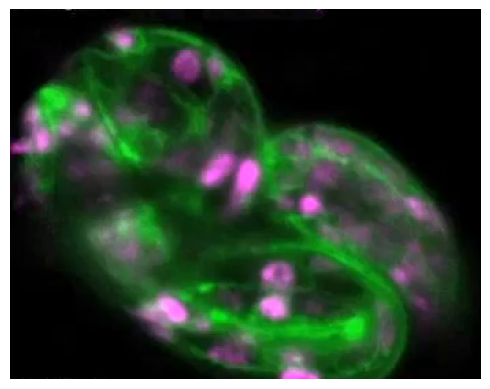

In [5]:
#DataLoader Sanity Check!
testGrid = torch.empty(video[currFrame].shape[0], video[currFrame].shape[1], 3).cpu()
testGrid = testGrid.type(torch.float64)
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=True)
for batch in iter(train_dataloader):
    coords = batch[0]
    pixels = batch[1]
    for i in range(0, len(coords)):
        row = coords[i][0]
        col = coords[i][1]
        pixel = pixels[i]
        testGrid[row][col] = pixel
#testGrid = torch.mul(testGrid, 1)
plt.imshow(testGrid.cpu());
plt.axis(False);

In [49]:
##Utils
import math
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [50]:
from pathlib import Path
def saveModel(modelPointer, psnr_note=35, frameNumber=0):
    # 1. Create models directory - won't create if it exists
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    # 2. Create model save path
    MODEL_NAME = "hashNerf_psnr_frame_"+frameNumber+"_psnr_"+str(psnr_note)+".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    MODEL_SAVE_PATH
    #3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=modelPointer.state_dict(),
            f=MODEL_SAVE_PATH)
    print(MODEL_SAVE_PATH)

In [56]:
#initialize model
model_0 = hashNerf(32, 128, 3)

In [57]:
lr1 = 0.0001
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)

In [59]:
# Training
from tqdm import tqdm
train_loader = DataLoader(training_data, batch_size=2048, shuffle=True)
batchCount = 0
psnr_table = []
savedAt25 = False
savedAt30 = False
for epoch in tqdm(range(0,50)):
    #Training
    model_0.train()
    if savedAt30 == True:
        break
    for batch in iter(train_loader):
        batchCount += 1
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        #print(y_train.shape)
        X = torch.tensor(batch[0]).type(torch.float64).to(device)
        y_train = torch.as_tensor(y_train).type(torch.float64).to(device)
        # Forward Pass
        y_pred = model_0(X).to(device).type(torch.float64)
        loss = loss_fn(y_pred, y_train)
        psnr = PSNR(loss, 1.0)
        psnr_table.append(psnr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (savedAt25 == False) and (psnr >= 25):
        saveModel(model_0, 25, 0)
        savedAt25 = True
    elif (savedAt30 == False) and (psnr >= 30):
        saveModel(model_0, 30, 0)
        savedAt30 = True
        break
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
    if epoch == 10:
        lr1 = lr1/10
    if epoch == 20:
        lr1 = lr1/2
print('Training Finished')

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_7252/699805323.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch[0]).type(torch.float64).to(device)
  2%|▏         | 1/50 [01:05<53:38, 65.69s/it]

Epoch: 0 | LR: 0.0001 | Train loss: 0.04924573769104057 | PSNR: 13.076313525240725


  2%|▏         | 1/50 [01:18<1:04:24, 78.86s/it]


KeyboardInterrupt: 

In [22]:
b = np.exp((np.log(512) - np.log(16)) / (16 - 1))
#print(b)
a = np.float32(16 * b ** np.arange(16))
a = torch.floor(torch.tensor(a).type(torch.int32)).to(device)
#print(a.shape)
#print(a)
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
tempX = torch.tensor([[1,1],
                      [1,2],
                      [2,4],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [10,2],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [0,1],
                      [2.1, 10.1],
                      [1,1]
                      ])
for batch in iter(train_dataloader):
    tempX = batch[0]
    break
tempX1 = tempX[:,[0]]
tempX2 = tempX[:,[1]]
tempX1 = tempX1 * a
tempX2 = tempX2 * a
#print(tempX1.shape)
#print(tempX2.shape)
tempConstruct = torch.hstack((tempX1, tempX2))
#print(tempX)
#print(tempConstruct)
outputT = torch.zeros((len(tempX), 2, 16)).type(torch.float32)
for i in range(len(tempX1)):
    outputT[i][0] = tempX[i][0] * a
    outputT[i][1] = tempX[i][1] * a


#print(outputT)
#print(outputT.shape)

verts = torch.transpose(torch.tensor([
                        [0,0],
                        [1,0],
                        [0,1],
                        [1,1]]), 0,1).type(torch.float32) # dim : (2,4)

outputVertices = torch.zeros((len(outputT), 2, 16, 4))
for i in range(len(outputT)):
    # make sure to do x and y !
    for j in range(0,16):
        outputVertices[i][0][j] = outputT[i][0][j] * verts[0]
        outputVertices[i][1][j] = outputT[i][1][j] * verts[1]
outputVertices = torch.floor(outputVertices).type(torch.int64)
#print(outputVertices)
print(outputVertices.shape)
primesTemp = torch.tensor([1, 2654435761]).type(torch.int64)
x_to_hash_temp = outputVertices * primesTemp[None, :, None, None]
#print(x_to_hash_temp)
print(x_to_hash_temp.shape)

x_hash_temp = torch.bitwise_xor(x_to_hash_temp[:, 0],
                                  x_to_hash_temp[:, 1]) # shape: num_points, L, 4
x_hash_temp = torch.remainder(x_hash_temp, 2) 

#### Begin sketchy code

debug_hash_table = torch.FloatTensor(16, 2**18, 2).uniform_(-1e-4, 1e-4)
print(x_hash_temp.shape)
x_hash_temp = x_hash_temp.permute(1, 0, 2)  # shape: L, num_points, 4
print('hash table shape:', debug_hash_table.shape)
print('x_hash shape:', x_hash_temp.shape)
# lookup hash table:
def gather(a):
    return torch.gather(a[0], 0, a[1].unsqueeze(2).expand(-1, -1, 2))

lookup = torch.stack([gather((debug_hash_table, x_hash_temp[i])) for i in range(16)], dim=0) # shape: L, numPoints , 4, 2
print(lookup.shape)
lookup = lookup.permute(1,0,2,3)  # shape: num_points, L, 4, F

print('lookup shape:', lookup.shape)
#interpolation
weights_temp =  outputT - torch.floor(outputT)
fx = weights_temp[:, 0, :]
cx = 1 - fx
fy = weights_temp[:, 1, :]
cy = 1 - fy

f11 = fx * fy
f10 = fx * cy
f01 = cx * fy
f00 = cx * cy

f_stack_temp = torch.stack([f00, f01, f10, f11], dim=2)  # shape: num_points, L, 4
print(f_stack_temp.shape)
x_interp = torch.sum(f_stack_temp[:, :, :, None] * lookup, dim=2)  # shape: num_points, L, F
print(x_interp.shape)
x = x_interp.reshape(-1, 16*2) # dim : num_points, L*F
print(x.shape)

torch.Size([256, 2, 16, 4])
torch.Size([256, 2, 16, 4])
torch.Size([256, 16, 4])
hash table shape: torch.Size([16, 262144, 2])
x_hash shape: torch.Size([16, 256, 4])
torch.Size([16, 256, 4, 2])
lookup shape: torch.Size([256, 16, 4, 2])
torch.Size([256, 16, 4])
torch.Size([256, 16, 2])
torch.Size([256, 32])


In [13]:
L=16
T=2**18
F=2
N_min=16
N_max=512
temp = torch.FloatTensor(L, T,F).uniform_(-1e-4, 1e-4)
print(temp)
print(temp.shape)


tensor([[[ 5.9389e-05, -5.5447e-05],
         [-1.1209e-05,  6.1000e-05],
         [-6.9846e-05, -8.2321e-05],
         ...,
         [-5.3848e-05,  2.4687e-05],
         [ 3.0202e-05,  7.6156e-05],
         [ 8.4700e-05,  4.6343e-05]],

        [[ 2.7111e-05, -9.0096e-05],
         [-9.2029e-06,  6.3181e-05],
         [-5.7037e-05, -2.1538e-05],
         ...,
         [-2.4205e-05, -7.6291e-06],
         [-1.5806e-05,  1.2426e-05],
         [-2.5164e-05,  5.3561e-05]],

        [[ 2.2662e-05, -2.4646e-05],
         [ 8.4154e-05, -7.5529e-06],
         [-9.0923e-05,  1.0564e-05],
         ...,
         [ 7.3005e-05, -5.4923e-06],
         [-8.6069e-05,  9.4029e-05],
         [ 8.7870e-05, -4.2551e-05]],

        ...,

        [[ 9.2899e-05,  7.7094e-05],
         [-5.2735e-05, -6.6905e-06],
         [-5.7840e-05, -3.4860e-05],
         ...,
         [ 2.2099e-05,  8.6120e-06],
         [-6.1649e-05,  1.4428e-05],
         [-1.1014e-05,  2.4512e-05]],

        [[ 5.8661e-05,  1.2266e-05

In [20]:
a_temp = torch.transpose(torch.tensor([
                        [0,0],
                        [1,0],
                        [0,1],
                        [1,1]]), 0,1).type(torch.float32)
print(a_temp[0])

tensor([0., 1., 0., 1.])


In [22]:
quit()

: 